Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
import logging

In [2]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [3]:
import warnings; warnings.simplefilter('ignore')
import re
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from scipy.stats import mode
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline
import seaborn as sns
from sklearn.datasets import load_digits

In [4]:
digits = load_digits()
X=digits.data
y=digits.target
(1797, 64)

(1797, 64)

In [5]:
print(X.shape, y.shape)

(1797, 64) (1797,)


**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

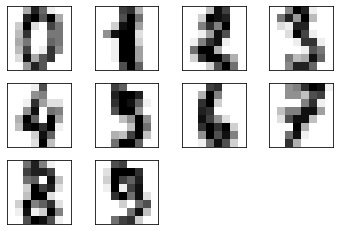

In [6]:
#Three lines:
num,dd = X.shape
X2 = X.reshape([num,8,8])
X2=15-X2
plt.gray() 
for i in range (0,10,1):
    plt.subplot(3, 4, i+1)
    plt.imshow(X2[i],interpolation=None) 
    plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)



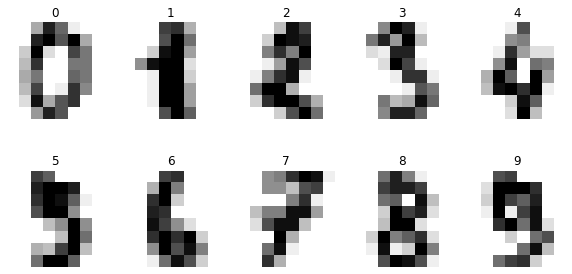

In [7]:
#Two lines:
_, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r )
    ax.set_title(label)

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [8]:
kmeans = KMeans(n_clusters=10, n_init=100,random_state=0)
kmeans_predict=kmeans.fit_predict(X)

In [9]:
kmeans_predict.shape

(1797,)

In [10]:
agg_clustering=AgglomerativeClustering(n_clusters=10)
agg_clustering_predict=AgglomerativeClustering(n_clusters=10).fit_predict(X)

In [11]:
agg_clustering_predict.shape

(1797,)

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [12]:
kmeans_cent_orig=kmeans.cluster_centers_

In [13]:
clf = NearestCentroid()

In [14]:
clf.fit(X, kmeans_predict)
kmeans_cent=clf.centroids_
kmeans = KMeans(n_clusters=10, n_init=100,random_state=0)
kmeans_cent_target=kmeans.fit_predict(kmeans_cent)

In [15]:
clf = NearestCentroid()
clf.fit(X, agg_clustering_predict)
agg_cent=clf.centroids_;

In [16]:
agg_clustering=AgglomerativeClustering(n_clusters=10)
agg_cent_target=AgglomerativeClustering(n_clusters=10).fit_predict(agg_cent)

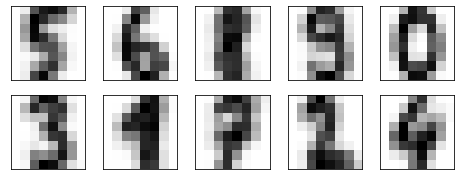

In [17]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans_cent_orig.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

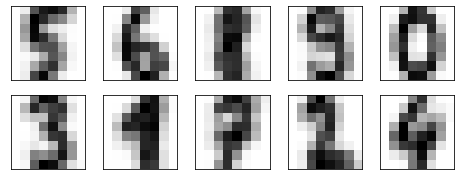

In [18]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans_cent.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

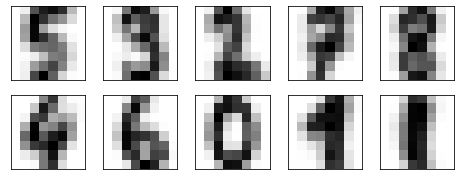

In [19]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = np.array(agg_cent).reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

####  We could make assumption that after Kmeans digits looks more clear. We will find out later that Kmeans is better on Silhouette than AgglomerativeClustering

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [20]:
def calculate_homogeneity_metrics(X,n_clusters_=11,step_=1,random_state_=42):
    df2 = pd.DataFrame()
    index_=[]
    for i in range(2,n_clusters_,step_):
        index_.append([str(i)+'K-means', str(i)+'Agglomerative'])
    index=np.array(index_).reshape(1,(n_clusters_-2)*2)
    data = []

    for i in range(2,11,1):
        algorithms = []
        algorithms.append(KMeans(n_clusters=i, n_init=100,random_state=random_state_))

        algorithms.append(AgglomerativeClustering(n_clusters=i))
        data = []
        for algo in algorithms:
            algo.fit(X)
            data.append(({ 
                'Homogenity': metrics.homogeneity_score(y, algo.labels_),
                'Completeness': metrics.completeness_score(y, algo.labels_),
                'V-measure': metrics.v_measure_score(y, algo.labels_),
                'Silhouette': metrics.silhouette_score(X, algo.labels_)}))
        results = pd.DataFrame(data=data, columns=[ 'Homogenity',
                                               'Completeness', 'V-measure', 
                                               'Silhouette'],
                           index=[str(i)+'K-means', str(i)+'Agglomerative'])
        results.to_csv(str(i)+'out.csv', index=True)
        df2 = df2.append(results)
    return df2

In [21]:
def homogeneity_metrics_results(X,n_clusters_=11,step_=1,random_state_=42):
    df2=calculate_homogeneity_metrics(X,n_clusters_=n_clusters_,step_=step_,random_state_=random_state_)
    df2.columns=['Homogenity','Completeness', 'V-measure','Silhouette']
    df2['metric']=df2.index
    df2 ['n_Cluster']=df2['metric'].apply(lambda x: int(re.findall(r'\d+', x)[0]))
    df2 ['Metric']=df2['metric'].apply(lambda x: re.sub('\d', '', x))
    del df2['metric']
    df2.set_index('n_Cluster', inplace=True)
    max_=df2['V-measure'].max()
    df_v=df2.loc[df2['V-measure'] == max_]
    max_=df2['Silhouette'].max()
    df_s=df2.loc[df2['Silhouette'] == max_]
    print ('best V-measure\n',df_v)
    print ('best Silhouette\n',df_s)
    f = plt.figure(figsize=(16,4))
    ax = f.add_subplot(121)
    df2.groupby('Metric')['V-measure'].plot(legend=True);
    plt.title('V-measure')
    ax2 = f.add_subplot(122)
    df2.groupby('Metric')['Silhouette'].plot(legend=True);
    plt.title('Silhouette')
    plt.show()
    return df2,df_v,df_s

best V-measure
            Homogenity  Completeness  V-measure  Silhouette         Metric
n_Cluster                                                                
10           0.857513      0.879096    0.86817    0.178497  Agglomerative
best Silhouette
            Homogenity  Completeness  V-measure  Silhouette   Metric
n_Cluster                                                          
9            0.691445      0.749628   0.719362    0.189153  K-means


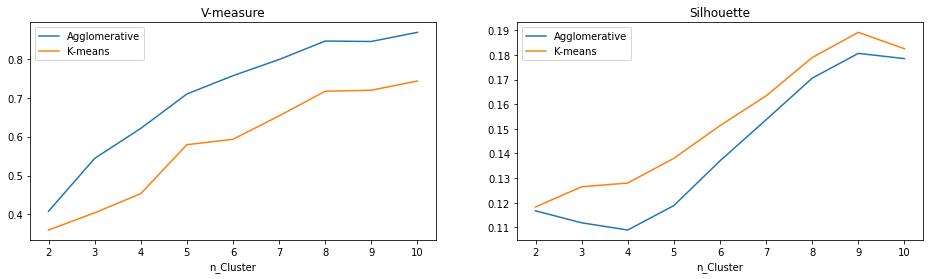

In [22]:
df,df_v,df_s=homogeneity_metrics_results(X)

### According to iterations we found that AgglomerativeClustering on 10 clusters perform better if appraisal in V-measure.

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

***********************************
  2
n_components  2
explained_variance_ratio_sum 0.1776090085399399
best V-measure
            Homogenity  Completeness  V-measure  Silhouette   Metric
n_Cluster                                                          
3            0.269597      0.581539   0.368405    0.407091  K-means
best Silhouette
            Homogenity  Completeness  V-measure  Silhouette   Metric
n_Cluster                                                          
2            0.136643      0.458644   0.210555    0.445526  K-means


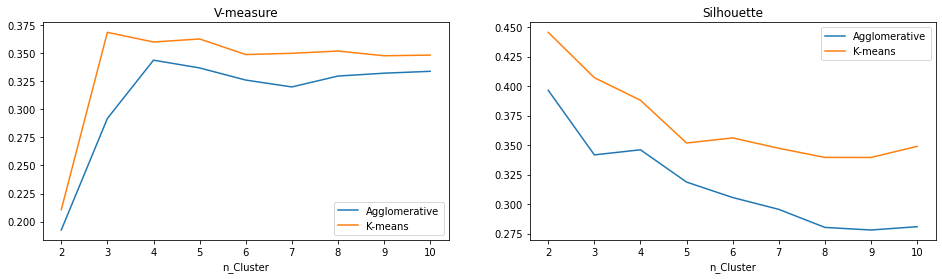

***********************************
  5
n_components  5
explained_variance_ratio_sum 0.5152668963785998
best V-measure
            Homogenity  Completeness  V-measure  Silhouette         Metric
n_Cluster                                                                
10           0.664737      0.686831   0.675604    0.272741  Agglomerative
best Silhouette
            Homogenity  Completeness  V-measure  Silhouette   Metric
n_Cluster                                                          
8            0.550786      0.634443   0.589662     0.31727  K-means


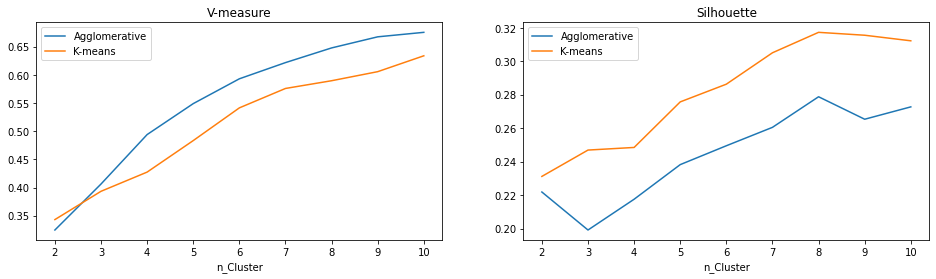

***********************************
  10
n_components  10
explained_variance_ratio_sum 0.7324265105015909
best V-measure
            Homogenity  Completeness  V-measure  Silhouette         Metric
n_Cluster                                                                
10           0.815761      0.836448   0.825975    0.250713  Agglomerative
best Silhouette
            Homogenity  Completeness  V-measure  Silhouette   Metric
n_Cluster                                                          
9             0.67197      0.727973   0.698852    0.270744  K-means


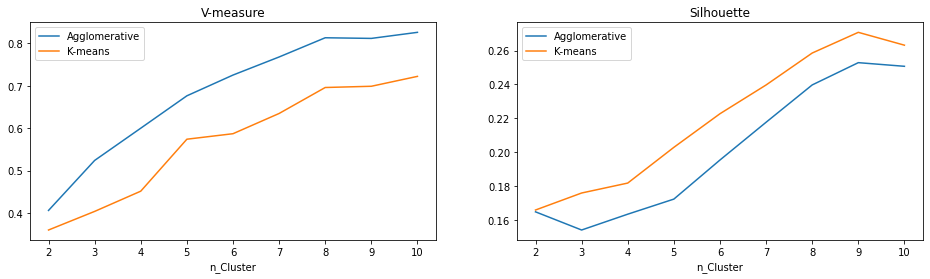

***********************************
  20
n_components  20
explained_variance_ratio_sum 0.8940623534941364
best V-measure
            Homogenity  Completeness  V-measure  Silhouette         Metric
n_Cluster                                                                
10            0.80214      0.832693   0.817131    0.195662  Agglomerative
best Silhouette
            Homogenity  Completeness  V-measure  Silhouette   Metric
n_Cluster                                                          
9             0.68888      0.746909   0.716722    0.219629  K-means


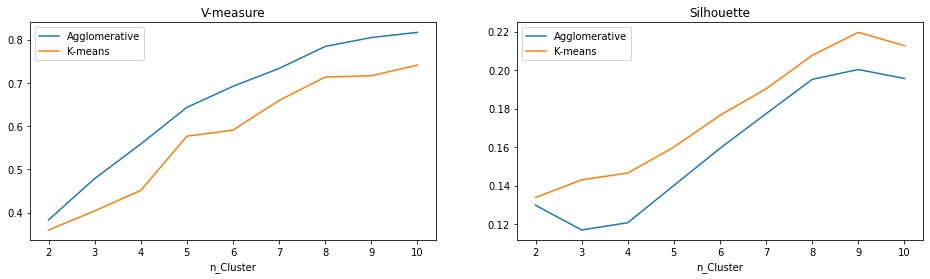

In [23]:
list_=[2, 5, 10, 20]
for j in list_:
    svd = TruncatedSVD(n_components=j, n_iter=100, random_state=42)
    Z=svd.fit_transform(X)
    print('***********************************\n ',j)
    print('n_components ',j)
    print('explained_variance_ratio_sum', svd.explained_variance_ratio_.sum())
    df_svd,df_svd_v,df_svd_s=homogeneity_metrics_results(Z)

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
The V-measure is the harmonic mean between homogeneity and completeness.
#### With n_components = 2 received max Silhouette=0.445526  on  Kmeans with 2 clusters, which is less than without TruncatedSVD
#### With n_components = 20 received max V-measure=0.817131  on  Agglomerative with 10 clusters, which is less than without TruncatedSVD. Explained_variance_ratio increase with higher number of components. We can explain 90% of the initial data dispersion with 20 components.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [24]:
# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=42)
digits_proj = tsne.fit_transform(X)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)
centers = kmeans.cluster_centers_.reshape(10,2)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9443516972732332

In [25]:
labels

array([0, 1, 8, ..., 8, 9, 8], dtype=int32)

In [26]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

def scatter(x, colors,centers):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
#     txts = []
    for i in range(10):
        # Position of each label.
#         xtext, ytext = np.median(x[colors == i, :], axis=0)
#         txt = ax.text(xtext, ytext, str(i), fontsize=24)
#         txt.set_path_effects([
#             PathEffects.Stroke(linewidth=5, foreground="w"),
#             PathEffects.Normal()])
#         txts.append(txt)
        plt.scatter(centers[i,0],centers[i,1],color='black')

    return f, ax, sc #, txts

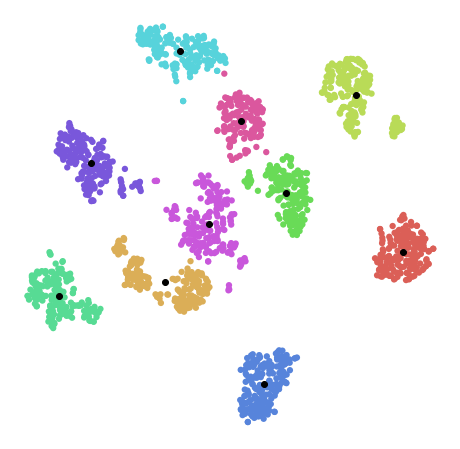

In [27]:
scatter(digits_proj, labels,centers);

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

best V-measure
            Homogenity  Completeness  V-measure  Silhouette         Metric
n_Cluster                                                                
10           0.909723      0.911019   0.910371    0.639427  Agglomerative
best Silhouette
            Homogenity  Completeness  V-measure  Silhouette   Metric
n_Cluster                                                          
10           0.909545      0.910778   0.910161    0.639613  K-means


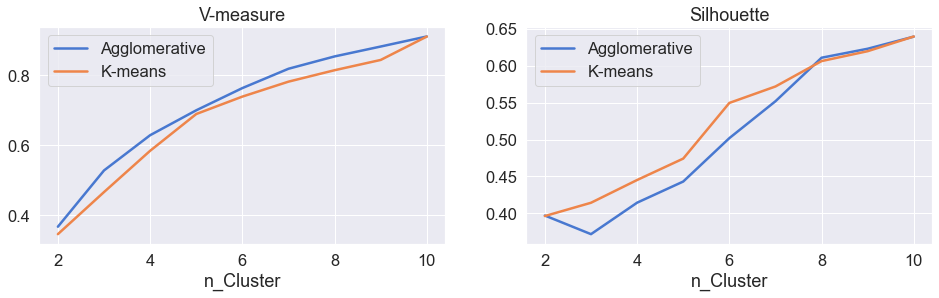

In [28]:
for i in range(10,11,10):
    df_svd,df_svd_v,df_svd_s=homogeneity_metrics_results(digits_proj)

### After tSNE  Silhouette and V-measure on  Kmeans and  AgglomerativeClustering  with 10 clusters is quit close on both methods and much better than on previous results.

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

In [29]:
agg_clustering=AgglomerativeClustering(n_clusters=10)
agg_clustering.fit(digits_proj)
agg_clustering_predict=agg_clustering.fit_predict(digits_proj)

clf = NearestCentroid()
clf.fit(digits_proj, agg_clustering_predict)
agg_cent=clf.centroids_

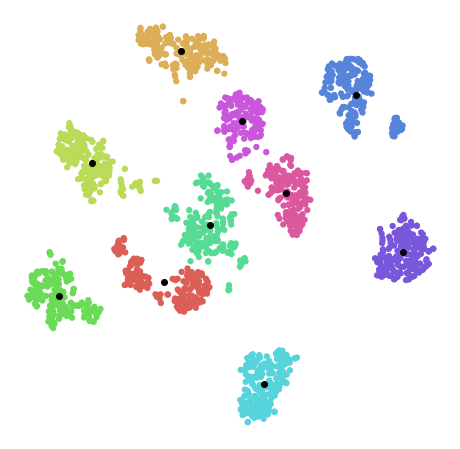

In [30]:
scatter(digits_proj, agg_clustering_predict,agg_cent);

### As after tSNE  Silhouette and V-measure on  Kmeans and  AgglomerativeClustering  with 10 clusters is quit close on both methods, picture almost haven't changed. Looks like we archieved separation of digits on unique clusters

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

1. According to iterations on number of clusters we found that AgglomerativeClustering on 10 clusters perform better if apprais in V-measure.
2. With n_components = 2 received max Silhouette=0.445526 on Kmeans with 2 clusters, which is less than without TruncatedSVD.
3. With n_components = 20 received max V-measure=0.817131 on AgglomerativeClustering with 10 clusters, which is less than without TruncatedSVD.
4. Explained_variance_ratio increase with higher number of components. We can explain 90% of the initial data dispersion with 20 components
5. After tSNE Silhouette and V-measure on Kmeans and AgglomerativeClustering with 10 clusters is quit close on both methods and much better than on previous results.
6. Hierarchical clustering gives slightly more meaningful clusters than kmeans. In general, with an increase in clusters, the result in the V-measure improves, and in the silhouette it decreases.
7. The quality of clustering can be improved by reducing the dimension of the feature space by reducing noise
8. The t-SNE algorithm provides an effective method to visualize a complex dataset. It successfully uncovers hidden structures in the data, exposing natural clusters and smooth nonlinear variations along the dimensions. But unfortunatelly it is unscalable to large datasets.


**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](https://stackoverflow.com/a/60450028). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [31]:
import warnings

from sklearn.datasets import fetch_openml
from sklearn.exceptions import ConvergenceWarning

print(__doc__)

# Load data from https://www.openml.org/d/554
Xd, yd = fetch_openml('mnist_784', version=1, return_X_y=True)

Automatically created module for IPython interactive environment


In [32]:
Xd.shape,yd.shape

((70000, 784), (70000,))

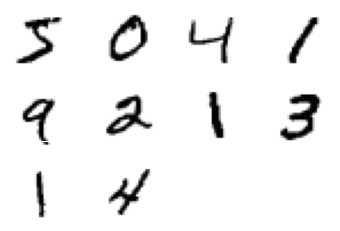

In [33]:
num,dd = Xd.shape
X2 = Xd.reshape([num,28,28])
X2=15-X2
plt.gray() 
for i in range (0,10,1):
    plt.subplot(3, 4, i+1)
    plt.imshow(X2[i],interpolation=None) 
    plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)




#### TSNE need too much resources will use  Incremental PCA

In [34]:


# tsne = TSNE(n_components=2, init='random', random_state=42)
# digits_proj = tsne.fit_transform(Xd)
# agg_clustering=AgglomerativeClustering(n_clusters=10)
# agg_clustering_predict=AgglomerativeClustering(n_clusters=10).fit_predict(digits_proj)


# clf = NearestCentroid()
# clf.fit(Xd, agg_clustering_predict)
# agg_cent=clf.centroids_

# fig, ax = plt.subplots(2, 5, figsize=(8, 3))
# centers = agg_cent.reshape(10, 28, 28)
# for axi, center in zip(ax.flat, centers):
#     axi.set(xticks=[], yticks=[])
#     axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [35]:
from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=2, batch_size=10)
ipca.fit(Xd)
X_reduced=ipca.transform(Xd) 

In [36]:
X_reduced.shape

(70000, 2)

Our data has 284 dimensions, but we are going to reduce it to only 2 and see that, even with just 2 dimensions, we can clearly see that digits separate into clusters.


Projecting 64-dimensional data to 2D


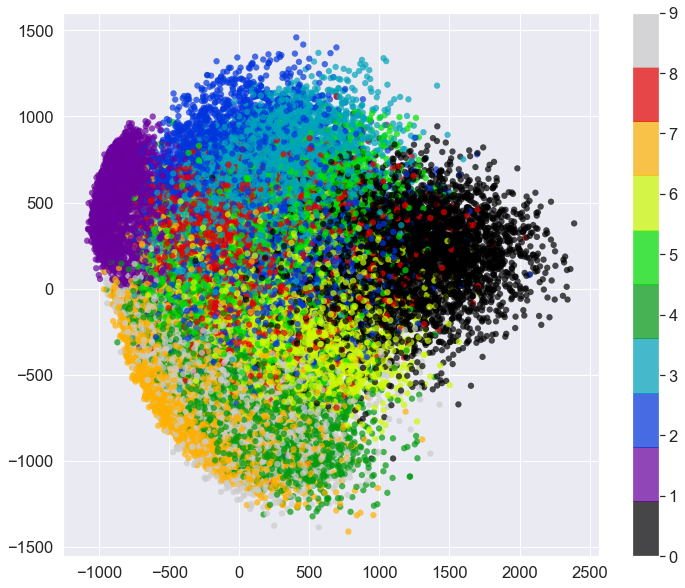

In [37]:
ipca = IncrementalPCA(n_components=2, batch_size=500)
ipca.fit(Xd)
X_reduced=ipca.transform(Xd) 
print('Projecting %d-dimensional data to 2D' % X.shape[1])
#  c=palette[colors.astype(np.int)])
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=yd.astype(np.int), 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()

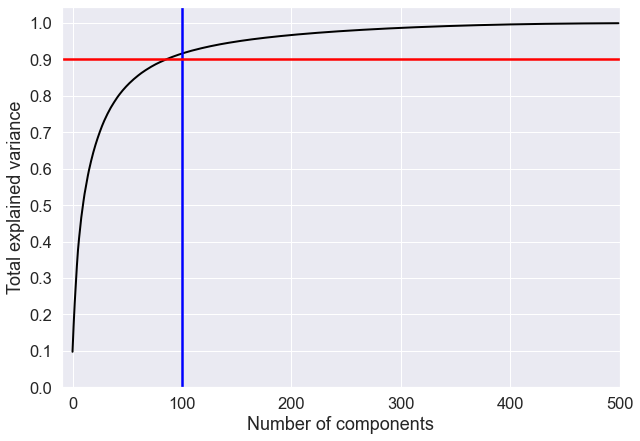

In [38]:
ipca = IncrementalPCA(n_components=500, batch_size=500)
ipca.fit(Xd)
X_reduced=ipca.transform(Xd) 

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(ipca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(-10, 500)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(100, c='b')
plt.axhline(0.9, c='r')
plt.show();

In practice, we would choose the number of principal components such that we can explain 90% of the initial data dispersion (via the explained_variance_ratio). Here, that means retaining 84 principal components; therefore, we reduce the dimensionality from 784 features to 84.

Projecting 64-dimensional data to 2D


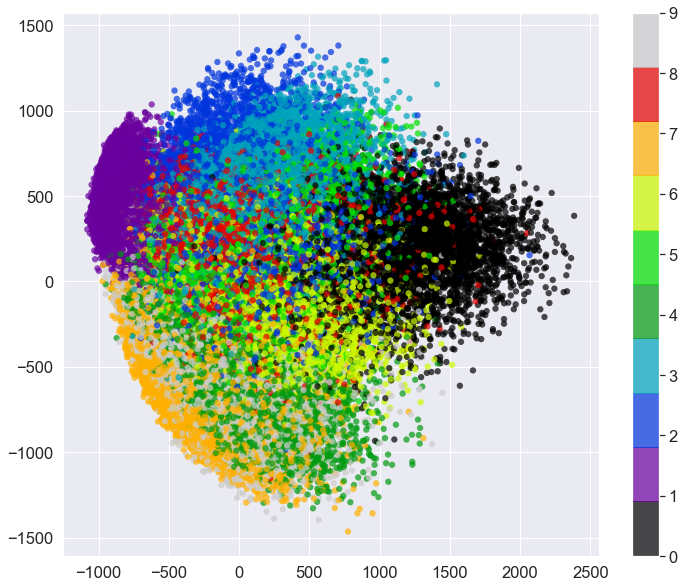

In [39]:
ipca = IncrementalPCA(n_components=100, batch_size=500)
ipca.fit(Xd)
X_reduced=ipca.transform(Xd) 
print('Projecting %d-dimensional data to 2D' % X.shape[1])
#  c=palette[colors.astype(np.int)])
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=yd.astype(np.int), 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()

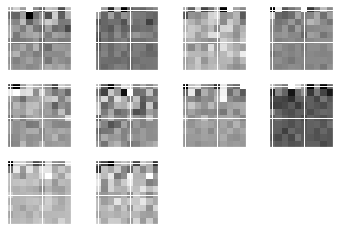

In [40]:
ipca = IncrementalPCA(n_components=100, batch_size=500)
ipca.fit(Xd)
X_reduced=ipca.transform(Xd) 
num,dd = X_reduced.shape
X2 = X_reduced.reshape([num,10,10])
X2=15-X2
plt.gray() 
for i in range (0,10,1):
    plt.subplot(3, 4, i+1)
    plt.imshow(X2[i], interpolation='nearest', cmap=plt.cm.binary) 
    plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)




Треш конечно, но как есть